# MMF1921 (Summer 2024) - Project 1
 
 The purpose of this program is to implement the following factor models
 
     a) Multi-factor OLS regression
     b) Fama-French 3-factor model
     c) LASSO
     d) Best Subset Selection
 
 and to use these factor models to estimate the asset expected returns and covariance matrix. 
 
These parameters will then be used to test the out-of-sample performance using MVO to construct optimal portfolios.
 
 Use can use this template to write your program.

     Student Name: Kaiwen Shen; 
     Student ID: 1009970239;

In [67]:
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from functions.BSS import *
from functions.FF import *
from functions.LASSO import *
from functions.MVO import *
from functions.OLS import *
import pandas as pd

adjClose = pd.read_csv("MMF1921_AssetPrices.csv", index_col=0)
factorRet = pd.read_csv("MMF1921_FactorReturns.csv", index_col=0)

In [69]:
adjClose.index = pd.to_datetime(adjClose.index)
factorRet.index = pd.to_datetime(factorRet.index)

In [70]:
#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:, factorRet.columns != 'RF'];

In [71]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates = factorRet.index

In [72]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]

returns = returns - np.diag(riskFree.values) @ np.ones_like(returns.values)
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:, :]

In [73]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Construct and rebalance your portfolios

Here you will estimate your input parameters (exp. returns and cov. matrix etc) from the Fama-French factor models.
You will have to re-estimate your parameters at the start of each rebalance period, and then re-optimize and rebalance your portfolios accordingly.

Ensure you re-initialize the dates above if you run this cell repeatedly. 

In [306]:
"""here I modified the code to a function for easier hyperparameter tuning"""


def back_test(lambda_, K):
    #Initial budget to invest ($100,000)
    initialVal = 100000

    #Start of in-sample calibration period
    calStart = pd.to_datetime('2008-01-01', format='%Y-%m-%d')
    calEnd = calStart + pd.offsets.DateOffset(years=4) - pd.offsets.DateOffset(days=1)

    #Start of out-of-sample test period
    testStart = pd.to_datetime('2012-01-01', format='%Y-%m-%d')
    testEnd = testStart + pd.offsets.DateOffset(years=1) - pd.offsets.DateOffset(days=1)

    #Number of investment periods (each investment period is 1 year long)
    NoPeriods = 5

    #Factor models
    #Note: You must populate the functions OLS.py, FF.py, LASSO.py and BSS.py with your own code.
    FMList = [OLS, FF, LASSO, BSS]
    NoModels = len(FMList)

    #Tags for the portfolios under the different factor models
    tags = ['OLS portfolio', 'FF portfolio', 'LASSO portfolio', 'BSS portfolio']
    # Initiate counter for the number of observations per investment period
    toDay = 0

    # Preallocate the space for the per period value of the portfolios 
    currentVal = {i: np.zeros(NoPeriods) for i in range(NoModels)}

    # Number of assets
    n = len(tickers)

    # Preallocate space for the portfolio weights
    x = {i: np.zeros([n, NoPeriods]) for i in range(NoModels)}

    # Initialize dictionaries to hold Q, mu and the number of shares 
    # for each model. These are overwritten at each rebalancing point
    mu = {}
    Q = {}
    total_IS_adj_r2 = []
    total_OOS_adj_r2 = []
    NoShares = {}

    # Empty lists to measure the value of the portfolio over the period
    portfValue = {i: [] for i in range(NoModels)}

    #--------------------------------------------------------------------------
    # Set the value of lambda and K for the LASSO and BSS models, respectively
    #--------------------------------------------------------------------------
    # lambda_ = 0.5
    # K = 4

    for t in range(NoPeriods):
        IS_adj_r2 = {}
        OOS_adj_r2 = {}
        beta = {}
        # Subset the returns and factor returns corresponding to the current calibration period.
        periodReturns = returns[(calStart <= returns.index) & (returns.index <= calEnd)]
        periodFactRet = factorRet[(calStart <= factorRet.index) & (factorRet.index <= calEnd)]
        # Subset of oos test period
        OOSReturns = returns[(testStart <= returns.index) & (returns.index <= testEnd)]
        OOSFactRet = factorRet[(testStart <= factorRet.index) & (factorRet.index <= testEnd)]
        
        current_price_idx = (calEnd - pd.offsets.DateOffset(days=7) <= adjClose.index) & (adjClose.index <= calEnd)
        currentPrices = adjClose[current_price_idx]

        # Subset the prices corresponding to the current out-of-sample test period.
        periodPrices_idx = (testStart <= adjClose.index) & (adjClose.index <= testEnd)
        periodPrices = adjClose[periodPrices_idx]

        assert len(currentPrices) == 1
        # Set the initial value of the portfolio or update the portfolio value
        if t == 0:
            for i in range(NoModels):
                currentVal[i][0] = initialVal  # all models start with the same amount of $
        else:
            for i in range(NoModels):
                currentVal[i][t] = (currentPrices @ NoShares[i].values.T).squeeze()

        # Update counter for the number of observations per investment period
        fromDay = toDay
        toDay = toDay + len(periodPrices)

        # Calculate 'mu' and 'Q' using the 4 factor models.
        # Note: You need to write the code for the 4 factor model functions. 
        for i in range(NoModels):
            mu[i], Q[i], IS_adj_r2[FMList[i].__name__], OOS_adj_r2[FMList[i].__name__] = FMList[i](periodReturns, periodFactRet,OOSReturns,OOSFactRet,lambda_, K)

        # Optimize your portfolios to get the weights 'x'
        # Note: You need to write the code for MVO with no short sales
        for i in range(NoModels):
            # Define the target return as the geometric mean of the market 
            # factor for the current calibration period
            targetRet = gmean(periodFactRet.iloc[:, 0] + 1) - 1
            x[i][:, t] = MVO(mu[i], Q[i], targetRet)

            # Calculate the optimal number of shares of each stock you should hold
        for i in range(NoModels):
            # Number of shares your portfolio holds per stock
            NoShares[i] = x[i][:, t] * currentVal[i][t] / currentPrices

            # Weekly portfolio value during the out-of-sample window
            portfValue[i].append(periodPrices @ NoShares[i].values.T)

        # Update your calibration and out-of-sample test periods
        calStart = calStart + pd.offsets.DateOffset(years=1)
        calEnd = calStart + pd.offsets.DateOffset(years=4) - pd.offsets.DateOffset(days=1)

        testStart = testStart + pd.offsets.DateOffset(years=1)
        testEnd = testStart + pd.offsets.DateOffset(years=1) - pd.offsets.DateOffset(days=1)
        # append the adjusted r2
        total_IS_adj_r2.append(pd.DataFrame(IS_adj_r2).mean(axis=0))
        total_OOS_adj_r2.append(pd.DataFrame(OOS_adj_r2).mean(axis=0))
    for i in range(NoModels):
        portfValue[i] = pd.concat(portfValue[i], axis=0)

    # Overwrite into a dataframe
    portfValue = pd.DataFrame([portfValue[i].values.squeeze() for i in range(NoModels)],
                              index=tags, columns=portfValue[0].index).T
    return portfValue, x, total_IS_adj_r2, total_OOS_adj_r2

# 3. hyperparameter tuning

In [75]:
lambda_list = np.linspace(0.01, 2, 10)
adj_r2_is_lasso = []
adj_r2_oos_lasso = []
weighted_r2_lasso = []
for lambda_ in lambda_list:
    _, _, adj_r2_is, adj_r2_oos = back_test(lambda_, 4)
    lasso_adj_r2_is = pd.DataFrame(adj_r2_is).mean()['LASSO']
    lasso_adj_r2_oos = pd.DataFrame(adj_r2_oos).mean()['LASSO']
    weight = 0.8 * lasso_adj_r2_is + 0.2 * lasso_adj_r2_oos
    adj_r2_is_lasso.append(lasso_adj_r2_is)
    adj_r2_oos_lasso.append(lasso_adj_r2_oos)
    weighted_r2_lasso.append(weight)
    # print process
    print(f"lambda: {lambda_}, adj_r2_is: {lasso_adj_r2_is}, adj_r2_oos: {lasso_adj_r2_oos}, weighted: {weight}")

lambda: 0.01, adj_r2_is: 0.43103130179883864, adj_r2_oos: -4.283731162504169, weighted: -0.5119211910617629
lambda: 0.23111111111111113, adj_r2_is: 0.4049169575478661, adj_r2_oos: -1.9743264862174112, weighted: -0.07093173120518936
lambda: 0.45222222222222225, adj_r2_is: 0.37488810810936873, adj_r2_oos: -1.3576577710252966, weighted: 0.02837893228243571
lambda: 0.6733333333333333, adj_r2_is: 0.3439450449612781, adj_r2_oos: -1.0445029059207864, weighted: 0.06625545478486519
lambda: 0.8944444444444445, adj_r2_is: 0.31139542623416927, adj_r2_oos: -0.8587609370318992, weighted: 0.07736415358095558
lambda: 1.1155555555555556, adj_r2_is: 0.27669162286550925, adj_r2_oos: -0.7283785033449958, weighted: 0.07567759762340825
lambda: 1.3366666666666667, adj_r2_is: 0.24127224703625916, adj_r2_oos: -0.6543494538467018, weighted: 0.06214790685966695
lambda: 1.557777777777778, adj_r2_is: 0.20325001358815312, adj_r2_oos: -0.590583764326774, weighted: 0.04448325800516771
lambda: 1.778888888888889, adj_r

In [76]:
lambda_list[np.argmax(weighted_r2_lasso)]# optimal value of lambda=0.89444

0.8944444444444445

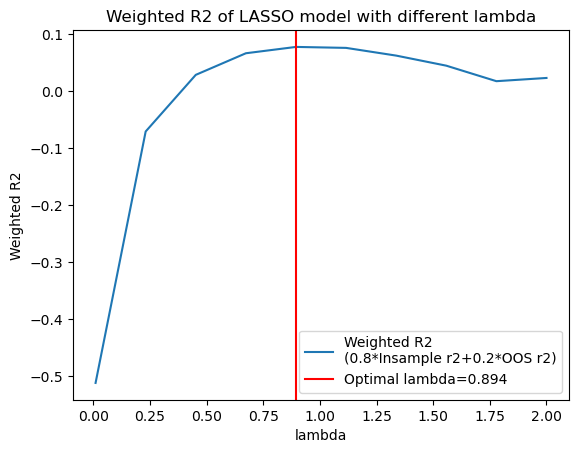

In [284]:
plt.plot(lambda_list, weighted_r2_lasso)
plt.axline((lambda_list[np.argmax(weighted_r2_lasso)], max(weighted_r2_lasso)), (lambda_list[np.argmax(weighted_r2_lasso)], 0), color='r')
plt.title('Weighted R2 of LASSO model with different lambda')
plt.xlabel('lambda')
plt.ylabel('Weighted R2')
plt.legend(['Weighted R2 \n(0.8*Insample r2+0.2*OOS r2)', f'Optimal lambda={ lambda_list[np.argmax(weighted_r2_lasso)]:.3f}'])
plt.show()

In [78]:
K_range = np.arange(1, 10)
adj_r2_is_bss = []
adj_r2_oos_bss = []
weighted_r2_bss = []
for k in K_range:
    portfValue, _, adj_r2_is, adj_r2_oos = back_test(0.5, k)
    bss_adj_r2_is = pd.DataFrame(adj_r2_is).mean()['BSS']
    bss_adj_r2_oos = pd.DataFrame(adj_r2_oos).mean()['BSS']
    weight = 0.8 * bss_adj_r2_is + 0.2 * bss_adj_r2_oos
    adj_r2_is_bss.append(bss_adj_r2_is)
    adj_r2_oos_bss.append(bss_adj_r2_oos)
    weighted_r2_bss.append(weight)
    port_ret = portfValue.pct_change().mean()['BSS portfolio']
    port_std = portfValue.pct_change().std()['BSS portfolio']
    # # print process
    # print(f"K: {k}, adj_r2_is: {bss_adj_r2_is}, adj_r2_oos: {bss_adj_r2_oos}, weighted: {weight}")

K: 1, adj_r2_is: 0.312886419126429, adj_r2_oos: -0.06955000437719105, weighted: 0.23639913442570504
K: 2, adj_r2_is: 0.4039407578212824, adj_r2_oos: -0.11466329707252887, weighted: 0.3002199468425202
K: 3, adj_r2_is: 0.44590176752088684, adj_r2_oos: -0.2677738513074583, weighted: 0.30316664375521785
K: 4, adj_r2_is: 0.46347701894564003, adj_r2_oos: -0.4854473357788825, weighted: 0.27369214800073555
K: 5, adj_r2_is: 0.46821986923507514, adj_r2_oos: -0.7813164514538282, weighted: 0.21831260509729447
K: 6, adj_r2_is: 0.46498388636613186, adj_r2_oos: -1.1946218029596845, weighted: 0.1330627485009686
K: 7, adj_r2_is: 0.45673176621812556, adj_r2_oos: -1.775651517793386, weighted: 0.010255109415823194
K: 8, adj_r2_is: 0.4452060546317022, adj_r2_oos: -2.700897343586923, weighted: -0.18401462501202276
K: 9, adj_r2_is: 0.4313080881282773, adj_r2_oos: -4.572510908302758, weighted: -0.5694557111579297


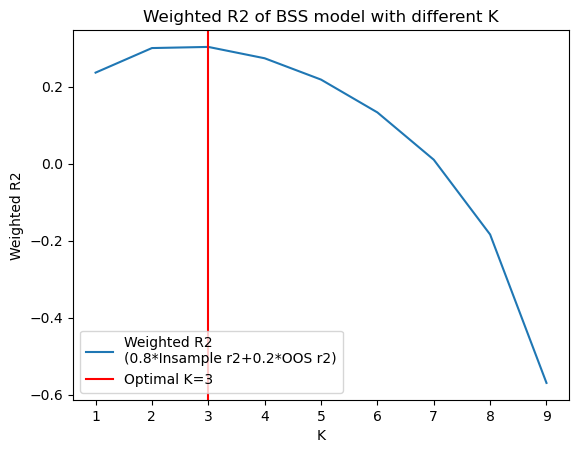

In [283]:
plt.plot(K_range, weighted_r2_bss)
plt.axline((K_range[np.argmax(weighted_r2_bss)], max(weighted_r2_bss)), (K_range[np.argmax(weighted_r2_bss)], 0), color='r')
plt.title('Weighted R2 of BSS model with different K')
plt.xlabel('K')
plt.ylabel('Weighted R2')
plt.legend(['Weighted R2\n(0.8*Insample r2+0.2*OOS r2)', f'Optimal K={ K_range[np.argmax(weighted_r2_bss)]}'])
plt.show()

In [80]:
K_range[np.argmax(weighted_r2_bss)]# optimal value of K=3

3

# 4. Results

In [322]:
portfValue, x, total_adj_r2, total_oos_adj_r2 = back_test(0.8944444444444445, 3)

In [323]:
pd.DataFrame(total_oos_adj_r2).mean()

OLS     -4.251564
FF      -0.386143
LASSO   -0.858761
BSS     -0.265611
dtype: float64

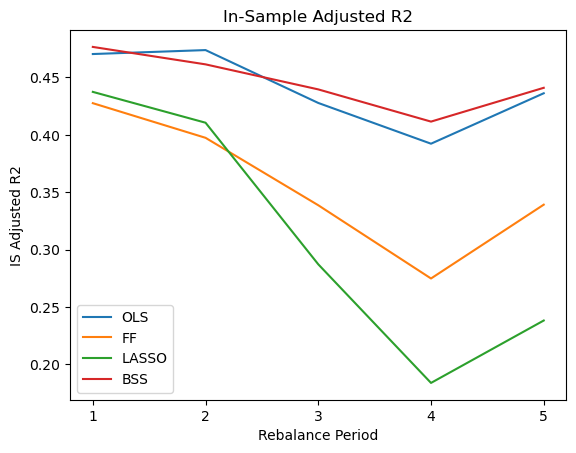

In [324]:
plt.plot(pd.DataFrame(total_adj_r2))
plt.legend(['OLS', 'FF', 'LASSO', 'BSS'])
plt.title('In-Sample Adjusted R2')
plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'])
plt.xlabel('Rebalance Period')
plt.ylabel('IS Adjusted R2')
plt.show()

In [325]:
pd.DataFrame(total_oos_adj_r2)

,OLS,FF,LASSO,BSS
0,-4.007314,-0.537115,-2.265779,-0.338531
1,-4.102324,-0.462272,-1.178072,-0.226442
2,-5.315139,-0.597139,-0.436665,-0.458766
3,-3.384919,0.037546,-0.134184,-0.013308
4,-4.448123,-0.371735,-0.279104,-0.291008


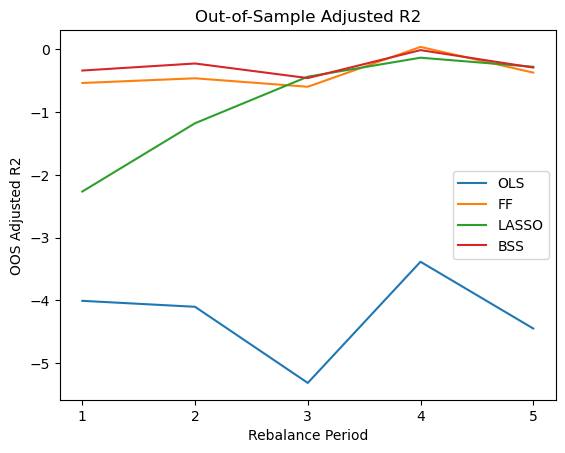

In [326]:
plt.plot(pd.DataFrame(total_oos_adj_r2))
plt.legend(['OLS', 'FF', 'LASSO', 'BSS'])
plt.title('Out-of-Sample Adjusted R2')
plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'])
plt.xlabel('Rebalance Period')
plt.ylabel('OOS Adjusted R2')
plt.show()

In [327]:
#--------------------------------------------------------------------------
# 4.1 Evaluate any measures of fit of the regression models to assess their
# in-sample quality. You may want to modify Section 3 of this program to
# calculate the quality of fit each time the models are recalibrated.
#--------------------------------------------------------------------------

#--------------------------------------------------------------------------
# 4.2 Calculate the portfolio average return, variance (or standard 
# deviation), and any other performance and/or risk metric you wish to 
# include in your report.
#--------------------------------------------------------------------------

In [328]:
# portfolio stats
portfolio_stats = pd.DataFrame()
portfolio_stats['Monthly return']=portfValue.pct_change().mean()
portfolio_stats['Annualized return']=portfValue.pct_change().mean()*12
portfolio_stats['Monthly volatility']=portfValue.pct_change().std()
portfolio_stats['Annualized volatility']=portfValue.pct_change().std()*np.sqrt(12)
portfolio_stats['Annualized Sharpe ratio']=portfolio_stats['Annualized return']/portfolio_stats['Annualized volatility']
portfolio_stats['Monthly Sharpe ratio']=portfolio_stats['Monthly return']/portfolio_stats['Monthly volatility']
portfolio_stats['Max Drawdown'] = (portfValue/portfValue.cummax()-1).min()

portfolio_stats.round(4)

,Monthly return,Annualized return,Monthly volatility,Annualized volatility,Annualized Sharpe ratio,Monthly Sharpe ratio,Max Drawdown
OLS portfolio,0.0028,0.0337,0.0298,0.1033,0.3259,0.0941,-0.1623
FF portfolio,0.0048,0.0576,0.0339,0.1175,0.4901,0.1415,-0.1374
LASSO portfolio,0.0049,0.0584,0.0303,0.1050,0.5564,0.1606,-0.1734
BSS portfolio,0.0032,0.0382,0.0303,0.1049,0.3643,0.1052,-0.1373


<Figure size 640x480 with 0 Axes>

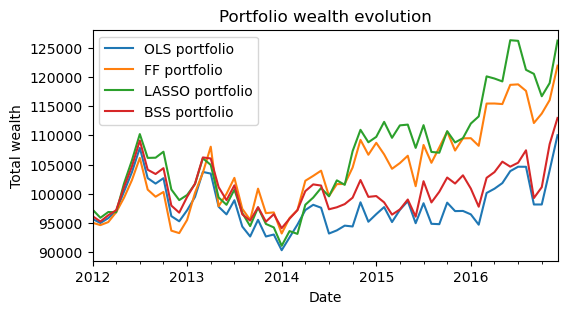

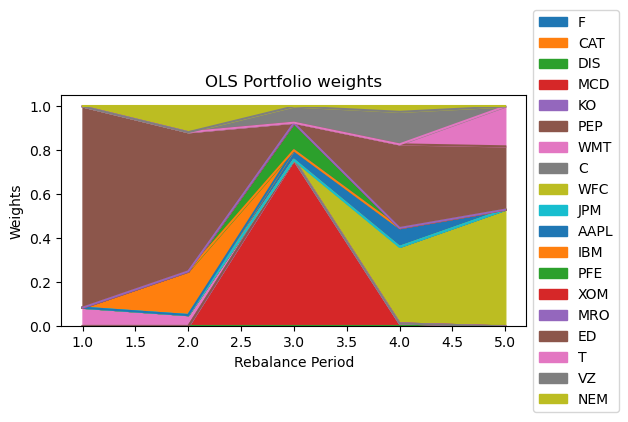

In [330]:
#--------------------------------------------------------------------------
# 4.3 Plot the portfolio wealth evolution 
# 
# Note: The code below plots all portfolios onto a single plot. However,
# you may want to split this into multiple plots for clarity, or to
# compare a subset of the portfolios. 
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title='Portfolio wealth evolution',
                ylabel='Total wealth',
                figsize=(6, 3),
                legend=True)
plt.savefig("images/wealth.svg")


#--------------------------------------------------------------------------
# 4.4 Plot the portfolio weights period-over-period
#--------------------------------------------------------------------------
# OLS Portfolio weights
def portfolio_weights_plot(name, idx):
    fig2 = plt.figure(2)
    x[idx][x[idx] < 0] = 0
    weights = pd.DataFrame(x[idx][(x[idx] > 0).any(axis=1)], index=tickers[(x[idx] > 0).any(axis=1)])
    weights.columns = [col + 1 for col in weights.columns]
    weights.T.plot.area(title=f'{name} Portfolio weights',
                        ylabel='Weights', xlabel='Rebalance Period',
                        figsize=(6, 3),
                        legend=True, stacked=True)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig(f"images/{name}_weights.svg")


portfolio_weights_plot('OLS', 0)
#
# ###########################################################################
# # Program End

<Figure size 640x480 with 0 Axes>

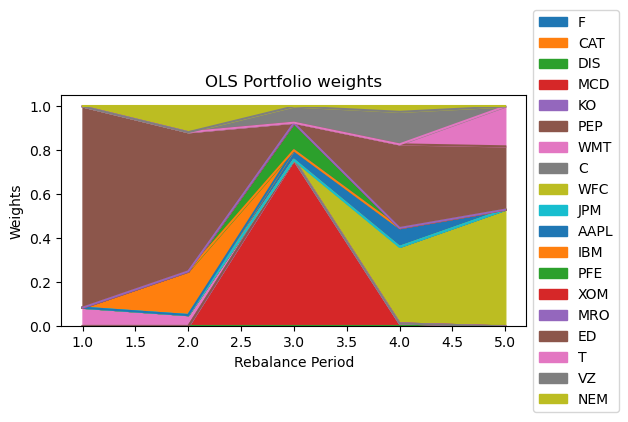

In [331]:
portfolio_weights_plot('OLS', 0)

<Figure size 640x480 with 0 Axes>

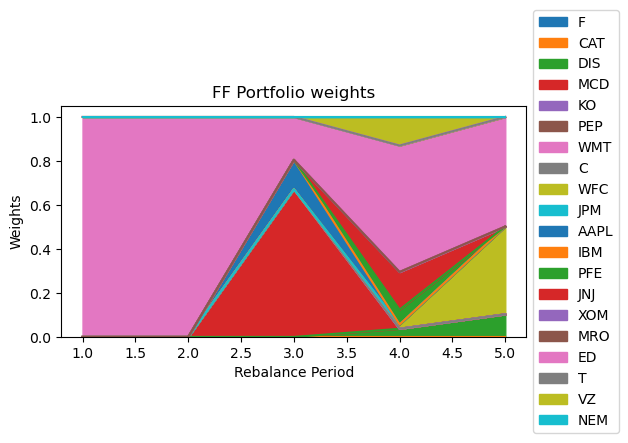

In [332]:
portfolio_weights_plot('FF', 1)

<Figure size 640x480 with 0 Axes>

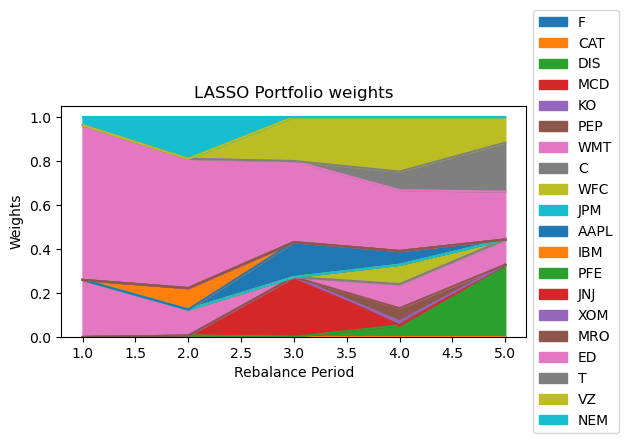

In [333]:
portfolio_weights_plot('LASSO', 2)

<Figure size 640x480 with 0 Axes>

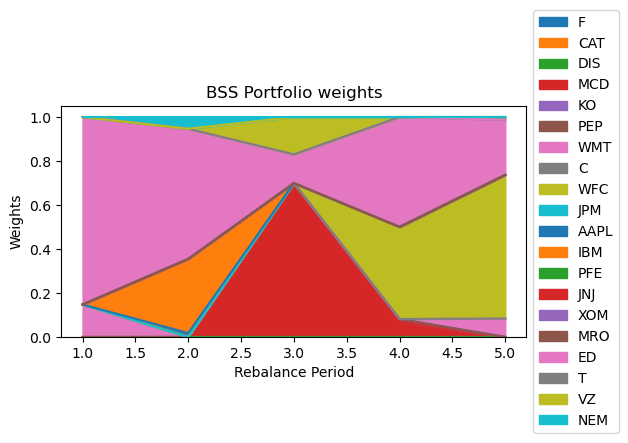

In [334]:
portfolio_weights_plot('BSS', 3)